In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

import statsmodels.api as sm

from math import sqrt

### Data Cleaning and Trimming Data 
- for uniformity

In [2]:
def data_split(data, all = False):

    data_copy = data.copy()
    
    if(all == False):            
        train_data = data_copy[:-365]
        test_data = data_copy[-365:]
    else:
        num_data = data_copy.shape[0]
        split_val = int(num_data*0.8)
        train_data = data_copy[:split_val]
        test_data = data_copy[split_val:]

    X_train = train_data[['Open','High','Low','Volume','Turnover']]
    Y_train = train_data[['Close']]

    X_test = test_data[['Open','High','Low','Volume','Turnover']]
    Y_test = test_data[['Close']]

    return X_train,Y_train,X_test,Y_test
    

In [3]:
def readData(path):
    data = pd.read_csv(path, index_col='Date', parse_dates=True, dayfirst=True)
    data = data.loc['2012-03-01': '2021-01-07']
    data.dropna(inplace = True)
    return data

### Analysis of Risk Vs Return

In [4]:
def volatility(data, Rf):
    
    Nifty = readData('../datasets/indices/NIFTY 50.csv')
    Nifty = Nifty.loc['2019-1-1':'2021-1-1']

    data = data.loc['2019-1-1':'2021-1-1']

    beta = np.cov(Nifty['Close'], data['Close'])[0][1]/data['Close'].var()

    alpha = (data['Close'][-1] - data['Close'][0])/data['Close'][0] - Rf + beta * ((Nifty['Close'][-1] - Nifty['Close'][0])/Nifty['Close'][0] - Rf)

    return (alpha, beta)

### Support Vector Regression

In [5]:
def SVRModel(Xtrain, Ytrain, Xtest, Ytest):
    
    i = 0.0001
    temp = []

    while(i <= 100):
        
        PipelineObject = Pipeline([('Scaler', StandardScaler()), ('svr', LinearSVR(C = i))])
        PipelineObject.fit(Xtrain,Ytrain)
        predictedSVR = PipelineObject.predict(Xtest)
        temp.append([PipelineObject, sqrt(metrics.mean_squared_error(Ytest, predictedSVR)), i])
        i = i * 10
    
    return (min(temp, key = lambda x: x[1]))

In [6]:
def SVRModelFinal(data, c):

    PipelineObject = Pipeline([('Scaler', StandardScaler()), ('svr', LinearSVR(C = c))])
    Xtrain = data[['Open','High','Low','Volume','Turnover']]
    Ytrain = data[['Close']]
    PipelineObject.fit(Xtrain,Ytrain)

    return PipelineObject

### Linear Regression

In [7]:
def LRModel(Xtrain, Ytrain, Xtest, Ytest):
    
    Regressor = LinearRegression()
    model = Regressor.fit(Xtrain, Ytrain)
    predictedLR = Regressor.predict(Xtest)
    
    return (model, sqrt(metrics.mean_squared_error(Ytest, predictedLR)))

In [8]:
def LRModelFinal(data):

    Regressor = LinearRegression()
    Xtrain = data[['Open','High','Low','Volume','Turnover']]
    Ytrain = data[['Close']]
    model = Regressor.fit(Xtrain, Ytrain['Close'].tolist())
    
    return model

### Decision Tree Regression

In [9]:
def DTRModel(Xtrain, Ytrain, Xtest, Ytest):

    min_rmse = -1
    min_model = None
    min_maxleaf =None
    
    for max_leaf_nodes in [5, 50, 500, 5000]:
    
        my_model,my_rmse = DTRGetRMSE(max_leaf_nodes, Xtrain, Xtest, Ytrain, Ytest)
    
        if min_rmse==-1 or min_rmse>my_rmse:
            min_rmse=my_rmse
            min_model = my_model
            min_maxleaf = max_leaf_nodes
    
    return (min_model,min_rmse,min_maxleaf)

In [10]:
def DTRModelFinal(data,c_max_leaf_nodes):

    Regressor = DecisionTreeRegressor(max_leaf_nodes=c_max_leaf_nodes)
    Xtrain = data[['Open','High','Low','Volume','Turnover']]
    Ytrain = data[['Close']]
    model = Regressor.fit(Xtrain, Ytrain['Close'].tolist())
    
    return model

In [11]:
def DTRGetRMSE(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    rmse = sqrt(metrics.mean_squared_error(val_y, preds_val))
    return model,rmse

### Random Forest Regression

In [12]:
def RFModel(Xtrain, Ytrain, Xtest, Ytest):

    min_rmse = -1
    min_model = None
    min_maxleaf =None
    
    for max_leaf_nodes in [5, 50, 500, 5000]:
    
        my_model,my_rmse = RFGetRMSE(max_leaf_nodes, Xtrain, Xtest, Ytrain, Ytest)
    
        if min_rmse==-1 or min_rmse>my_rmse:
    
            min_rmse=my_rmse
            min_model = my_model
            min_maxleaf = max_leaf_nodes
    
    return min_model,min_rmse,min_maxleaf

In [13]:
def RFGetRMSE(max_leaf_nodes, train_X, val_X, train_y, val_y):
    
    model = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    rmse = sqrt(metrics.mean_squared_error(val_y, preds_val))
    
    return model,rmse

In [14]:
def RFModelFinal(data,c_max_leaf_nodes):

    Regressor = RandomForestRegressor(max_leaf_nodes=c_max_leaf_nodes)
    Xtrain = data[['Open','High','Low','Volume','Turnover']]
    Ytrain = data[['Close']]
    model = Regressor.fit(Xtrain, Ytrain['Close'].tolist())
    
    return model

# Forecasting Using Time-Series Models </br> * SARIMAX </br>* SARIMA

### SARIMAX Model To Predict Hyperparameters

In [15]:
def test_stationarity(timeseries):
    pval=-1
    #Perform Dickey-Fuller test:
    #print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    # print (dfoutput)
    return dfoutput["p-value"]

In [16]:
def SMXModel(X_train,Y_train,X_test,Y_test):

    pval = test_stationarity(Y_train)
    print('\n\n')

    if pval<=0.05:
        # print("Going without any de-trending/differencing")
        
        sxmodel = pm.auto_arima(Y_train,exogenous = X_train,
                           start_p=1, start_q=0,
                           test='adf',
                           max_p=2, max_q=2, m=16,
                           start_P=0,
                           d=None, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,n_jobs = -1,
                           random = True)

        sxmodel.summary()

        

    else:
        num_diff = ndiffs(Y_train.values, test='adf')
        # print("Needs de-trending/differencing :",num_diff)

        sxmodel = pm.auto_arima(Y_train,exogenous = X_train,
                           start_p=1, start_q=0,
                           test='adf',
                           max_p=2, max_q=2, m=16,
                           start_P=0,
                           d=None, D=num_diff, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,n_jobs = -1,
                           random = True)

        sxmodel.summary()

    # print("\n\n HERE")
    yPredS = sxmodel.predict(n_periods = len(Y_test), exogenous = X_test)

    rmse = sqrt(metrics.mean_squared_error(Y_test, yPredS ))
    # print("The root mean squared error is {}.".format(rmse))
        
    return sxmodel,rmse,sxmodel.order,sxmodel.seasonal_order

### SARIMA Model for Forecasting which we'll use in Alpha-Beta Analysis for Companies with their Index 

In [17]:
def Just_Sarima_Final(data,c_order,c_seasonal_order):
    Ytrain = data[['Close']]
    model = sm.tsa.statespace.SARIMAX(Ytrain, order=c_order,seasonal_order=c_seasonal_order)

    results = model.fit(disp=False)
    return results

In [18]:
data = readData('../datasets/companies/LICHSGFIN.csv')

In [19]:
X_train,Y_train,X_test,Y_test = data_split(data, True)

### Company-wise BruteForce Model Selection
- critrea RMSE

In [20]:
paths = ['../datasets/companies/BAJAJ-AUTO.csv', '../datasets/companies/BAJFINANCE.csv', '../datasets/companies/HDFCBANK.csv', '../datasets/companies/INFY.csv', '../datasets/companies/ITC.csv', '../datasets/companies/LICHSGFIN.csv', '../datasets/companies/PFIZER.csv', '../datasets/companies/RELIANCE.csv', '../datasets/companies/SBIN.csv', '../datasets/companies/TATAMOTORS.csv', '../datasets/companies/TCS.csv']
company = ["BAJAJ-AUTO", "BAJFINANCE", "HDFCBANK", "INFY", "ITC", "LICHSGFIN", "PFIZER", "RELIANCE", "SBIN", "TATAMOTORS", "TCS"]

modelSelection = []
final = []

for i in range(0, len(paths)):
    
    temp = []
    
    data = readData(paths[i])
    
    X_train,Y_train,X_test,Y_test = data_split(data, True)
    
    LR = LRModel(X_train, Y_train, X_test, Y_test)
    SVR = SVRModel(X_train, Y_train['Close'].tolist(), X_test, Y_test['Close'].tolist())
    DTR = DTRModel(X_train, Y_train, X_test, Y_test)
    RF = RFModel(X_train, Y_train, X_test, Y_test)
    SMX = SMXModel(X_train, Y_train, X_test, Y_test)

    temp.append(LR[1])
    temp.append(SVR[1])
    temp.append(DTR[1])
    temp.append(RF[1])
    temp.append(SMX[1])

    x = temp.index(min(temp))
    
    alpha, beta = volatility(data, 0.05)

    if(x == 0):
        final.append(["LR -", temp[0]])
        modelSelection.append([company[i], "LR", LRModelFinal(data), alpha, beta])
    elif(x == 1):
        final.append(["SVR -", temp[1]])
        modelSelection.append([company[i], "SVR", SVRModelFinal(data, SVR[2]), alpha, beta])
    elif(x == 2):
        final.append(["DTR -", temp[2]])
        modelSelection.append([company[i], "DTR", DTRModelFinal(data, DTR[2]), alpha, beta])
    elif(x == 3):
        final.append(["RF -", temp[3]])
        modelSelection.append([company[i], "RF", RFModelFinal(data, RF[2]), alpha, beta])
    elif(x == 4):
        final.append(["SMX -", temp[4]])
        modelSelection.append([company[i], "SMX", Just_Sarima_Final(data, SMX[2],SMX[3]), alpha, beta])

C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap




Performing stepwise search to minimize aic


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,1,1)[16] intercept   : AIC=14710.942, Time=9.63 sec
 ARIMA(0,0,0)(0,1,0)[16] intercept   : AIC=15457.524, Time=1.47 sec
 ARIMA(1,0,0)(1,1,0)[16] intercept   : AIC=15029.693, Time=9.87 sec
 ARIMA(0,0,1)(0,1,1)[16] intercept   : AIC=14712.143, Time=9.16 sec
 ARIMA(0,0,0)(0,1,0)[16]             : AIC=26692.625, Time=1.34 sec
 ARIMA(1,0,0)(0,1,0)[16] intercept   : AIC=15459.400, Time=2.02 sec
 ARIMA(1,0,0)(1,1,1)[16] intercept   : AIC=14714.402, Time=9.64 sec
 ARIMA(1,0,0)(0,1,2)[16] intercept   : AIC=inf, Time=23.96 sec
 ARIMA(1,0,0)(1,1,2)[16] intercept   : AIC=inf, Time=25.73 sec
 ARIMA(0,0,0)(0,1,1)[16] intercept   : AIC=14709.033, Time=7.76 sec
 ARIMA(0,0,0)(1,1,1)[16] intercept   : AIC=14712.494, Time=8.68 sec
 ARIMA(0,0,0)(0,1,2)[16] intercept   : AIC=inf, Time=21.40 sec
 ARIMA(0,0,0)(1,1,0)[16] intercept   : AIC=15027.748, Time=7.97 sec
 ARIMA(0,0,0)(1,1,2)[16] intercept   : AIC=inf, Time=24.99 sec


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_auto_solvers.py:40: RuntimeWarning: invalid value encountered in true_divide
  max_invroot = max(0, *np.abs(1 / model.maroots()))


 ARIMA(1,0,1)(0,1,1)[16] intercept   : AIC=14714.286, Time=12.30 sec
 ARIMA(0,0,0)(0,1,1)[16]             : AIC=14477.588, Time=6.67 sec
 ARIMA(0,0,0)(1,1,1)[16]             : AIC=14481.954, Time=7.53 sec
 ARIMA(0,0,0)(0,1,2)[16]             : AIC=inf, Time=19.11 sec
 ARIMA(0,0,0)(1,1,0)[16]             : AIC=14960.349, Time=6.96 sec
 ARIMA(0,0,0)(1,1,2)[16]             : AIC=inf, Time=21.37 sec
 ARIMA(1,0,0)(0,1,1)[16]             : AIC=14711.796, Time=7.60 sec
 ARIMA(0,0,1)(0,1,1)[16]             : AIC=14712.950, Time=8.06 sec


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_auto_solvers.py:40: RuntimeWarning: invalid value encountered in true_divide
  max_invroot = max(0, *np.abs(1 / model.maroots()))


 ARIMA(1,0,1)(0,1,1)[16]             : AIC=14715.173, Time=11.02 sec

Best model:  ARIMA(0,0,0)(0,1,1)[16]          
Total fit time: 264.290 seconds


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-13-




Performing stepwise search to minimize aic


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,1,1)[16] intercept   : AIC=17108.752, Time=8.65 sec
 ARIMA(0,0,0)(0,1,0)[16] intercept   : AIC=17827.917, Time=1.50 sec
 ARIMA(1,0,0)(1,1,0)[16] intercept   : AIC=17397.776, Time=9.30 sec
 ARIMA(0,0,1)(0,1,1)[16] intercept   : AIC=17112.382, Time=9.08 sec
 ARIMA(0,0,0)(0,1,0)[16]             : AIC=29062.713, Time=1.38 sec
 ARIMA(1,0,0)(0,1,0)[16] intercept   : AIC=17813.437, Time=2.10 sec
 ARIMA(1,0,0)(1,1,1)[16] intercept   : AIC=17129.419, Time=9.49 sec
 ARIMA(1,0,0)(0,1,2)[16] intercept   : AIC=17071.002, Time=24.63 sec
 ARIMA(1,0,0)(1,1,2)[16] intercept   : AIC=17074.858, Time=26.16 sec
 ARIMA(0,0,0)(0,1,2)[16] intercept   : AIC=17083.810, Time=21.49 sec
 ARIMA(2,0,0)(0,1,2)[16] intercept   : AIC=17058.814, Time=26.27 sec
 ARIMA(2,0,0)(0,1,1)[16] intercept   : AIC=17096.877, Time=9.56 sec
 ARIMA(2,0,0)(1,1,2)[16] intercept   : AIC=17062.760, Time=28.34 sec
 ARIMA(2,0,0)(1,1,1)[16] intercept   : AIC=17117.565, Time=10.90 sec
 ARIMA(2,0,1)(0,1,2)[16] intercept   : AIC

C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector




Performing stepwise search to minimize aic


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,1,1)[16] intercept   : AIC=11564.086, Time=8.67 sec
 ARIMA(0,0,0)(0,1,0)[16] intercept   : AIC=12320.893, Time=1.66 sec
 ARIMA(1,0,0)(1,1,0)[16] intercept   : AIC=11858.815, Time=8.92 sec
 ARIMA(0,0,1)(0,1,1)[16] intercept   : AIC=11565.556, Time=9.25 sec
 ARIMA(0,0,0)(0,1,0)[16]             : AIC=23556.865, Time=1.30 sec
 ARIMA(1,0,0)(0,1,0)[16] intercept   : AIC=12322.333, Time=2.01 sec
 ARIMA(1,0,0)(1,1,1)[16] intercept   : AIC=11581.311, Time=9.59 sec
 ARIMA(1,0,0)(0,1,2)[16] intercept   : AIC=inf, Time=24.07 sec
 ARIMA(1,0,0)(1,1,2)[16] intercept   : AIC=inf, Time=26.26 sec
 ARIMA(0,0,0)(0,1,1)[16] intercept   : AIC=11561.925, Time=7.76 sec
 ARIMA(0,0,0)(1,1,1)[16] intercept   : AIC=11579.199, Time=8.66 sec
 ARIMA(0,0,0)(0,1,2)[16] intercept   : AIC=inf, Time=21.97 sec
 ARIMA(0,0,0)(1,1,0)[16] intercept   : AIC=11857.100, Time=7.88 sec
 ARIMA(0,0,0)(1,1,2)[16] intercept   : AIC=inf, Time=23.97 sec
 ARIMA(1,0,1)(0,1,1)[16] intercept   : AIC=11566.602, Time=10.03 sec

C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector




Performing stepwise search to minimize aic


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,1,1)[16] intercept   : AIC=14227.137, Time=8.83 sec
 ARIMA(0,0,0)(0,1,0)[16] intercept   : AIC=14963.318, Time=1.72 sec
 ARIMA(1,0,0)(1,1,0)[16] intercept   : AIC=14525.452, Time=9.20 sec
 ARIMA(0,0,1)(0,1,1)[16] intercept   : AIC=14227.517, Time=9.21 sec
 ARIMA(0,0,0)(0,1,0)[16]             : AIC=26198.125, Time=1.34 sec
 ARIMA(1,0,0)(0,1,0)[16] intercept   : AIC=14962.030, Time=2.18 sec
 ARIMA(1,0,0)(1,1,1)[16] intercept   : AIC=14244.801, Time=9.69 sec
 ARIMA(1,0,0)(0,1,2)[16] intercept   : AIC=inf, Time=24.40 sec
 ARIMA(1,0,0)(1,1,2)[16] intercept   : AIC=14190.257, Time=26.50 sec
 ARIMA(1,0,0)(2,1,2)[16] intercept   : AIC=14195.369, Time=28.83 sec
 ARIMA(1,0,0)(2,1,1)[16] intercept   : AIC=14262.423, Time=26.54 sec
 ARIMA(0,0,0)(1,1,2)[16] intercept   : AIC=14190.858, Time=24.12 sec
 ARIMA(2,0,0)(1,1,2)[16] intercept   : AIC=14192.086, Time=28.39 sec
 ARIMA(1,0,1)(1,1,2)[16] intercept   : AIC=14191.804, Time=30.62 sec
 ARIMA(0,0,1)(1,1,2)[16] intercept   : AIC=1419

C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_auto_solvers.py:40: RuntimeWarning: invalid value encountered in true_divide
  max_invroot = max(0, *np.abs(1 / model.maroots()))


 ARIMA(2,0,1)(1,1,2)[16] intercept   : AIC=15143.670, Time=33.00 sec
 ARIMA(1,0,0)(1,1,2)[16]             : AIC=14188.341, Time=23.55 sec
 ARIMA(1,0,0)(0,1,2)[16]             : AIC=inf, Time=21.51 sec
 ARIMA(1,0,0)(1,1,1)[16]             : AIC=14242.830, Time=9.13 sec
 ARIMA(1,0,0)(2,1,2)[16]             : AIC=14193.448, Time=25.58 sec
 ARIMA(1,0,0)(0,1,1)[16]             : AIC=14225.136, Time=7.84 sec
 ARIMA(1,0,0)(2,1,1)[16]             : AIC=14260.471, Time=23.82 sec
 ARIMA(0,0,0)(1,1,2)[16]             : AIC=13919.656, Time=21.44 sec
 ARIMA(0,0,0)(0,1,2)[16]             : AIC=inf, Time=20.44 sec
 ARIMA(0,0,0)(1,1,1)[16]             : AIC=14026.010, Time=7.75 sec
 ARIMA(0,0,0)(2,1,2)[16]             : AIC=13927.753, Time=23.66 sec
 ARIMA(0,0,0)(0,1,1)[16]             : AIC=13997.493, Time=6.93 sec
 ARIMA(0,0,0)(2,1,1)[16]             : AIC=14054.026, Time=20.18 sec
 ARIMA(0,0,1)(1,1,2)[16]             : AIC=14188.718, Time=24.97 sec
 ARIMA(1,0,1)(1,1,2)[16]             : AIC=14189.9

C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector y was passed when 




Performing stepwise search to minimize aic


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,0,1)[16] intercept   : AIC=7446.870, Time=2.76 sec
 ARIMA(0,0,0)(0,0,0)[16] intercept   : AIC=7443.879, Time=0.40 sec
 ARIMA(1,0,0)(1,0,0)[16] intercept   : AIC=7446.792, Time=2.58 sec
 ARIMA(0,0,1)(0,0,1)[16] intercept   : AIC=7446.877, Time=2.78 sec
 ARIMA(0,0,0)(0,0,0)[16]             : AIC=18798.148, Time=0.39 sec
 ARIMA(0,0,0)(1,0,0)[16] intercept   : AIC=7445.787, Time=1.88 sec
 ARIMA(0,0,0)(0,0,1)[16] intercept   : AIC=7445.908, Time=2.25 sec
 ARIMA(0,0,0)(1,0,1)[16] intercept   : AIC=7447.917, Time=2.65 sec
 ARIMA(1,0,0)(0,0,0)[16] intercept   : AIC=7444.847, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[16] intercept   : AIC=7444.854, Time=0.56 sec
 ARIMA(1,0,1)(0,0,0)[16] intercept   : AIC=7446.836, Time=0.62 sec

Best model:  ARIMA(0,0,0)(0,0,0)[16] intercept
Total fit time: 17.406 seconds


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_b




Performing stepwise search to minimize aic


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,1,1)[16] intercept   : AIC=9253.643, Time=8.80 sec
 ARIMA(0,0,0)(0,1,0)[16] intercept   : AIC=9979.680, Time=1.66 sec
 ARIMA(1,0,0)(1,1,0)[16] intercept   : AIC=9538.108, Time=9.46 sec
 ARIMA(0,0,1)(0,1,1)[16] intercept   : AIC=9254.464, Time=9.25 sec
 ARIMA(0,0,0)(0,1,0)[16]             : AIC=21214.536, Time=1.43 sec
 ARIMA(1,0,0)(0,1,0)[16] intercept   : AIC=9981.676, Time=1.92 sec
 ARIMA(1,0,0)(1,1,1)[16] intercept   : AIC=9274.035, Time=9.77 sec
 ARIMA(1,0,0)(0,1,2)[16] intercept   : AIC=inf, Time=24.25 sec
 ARIMA(1,0,0)(1,1,2)[16] intercept   : AIC=9227.120, Time=26.58 sec
 ARIMA(1,0,0)(2,1,2)[16] intercept   : AIC=9233.354, Time=28.75 sec
 ARIMA(1,0,0)(2,1,1)[16] intercept   : AIC=9301.216, Time=26.37 sec
 ARIMA(0,0,0)(1,1,2)[16] intercept   : AIC=9224.819, Time=24.26 sec
 ARIMA(0,0,0)(0,1,2)[16] intercept   : AIC=inf, Time=22.07 sec
 ARIMA(0,0,0)(1,1,1)[16] intercept   : AIC=9271.870, Time=8.79 sec
 ARIMA(0,0,0)(2,1,2)[16] intercept   : AIC=9231.079, Time=27.38 s

C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-13-




Performing stepwise search to minimize aic


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,1,1)[16] intercept   : AIC=15191.669, Time=12.51 sec
 ARIMA(0,0,0)(0,1,0)[16] intercept   : AIC=15755.788, Time=2.21 sec
 ARIMA(1,0,0)(1,1,0)[16] intercept   : AIC=15444.033, Time=16.23 sec
 ARIMA(0,0,1)(0,1,1)[16] intercept   : AIC=15192.258, Time=14.82 sec
 ARIMA(0,0,0)(0,1,0)[16]             : AIC=26992.514, Time=1.84 sec
 ARIMA(1,0,0)(0,1,0)[16] intercept   : AIC=15757.788, Time=3.24 sec
 ARIMA(1,0,0)(1,1,1)[16] intercept   : AIC=15175.550, Time=15.88 sec
 ARIMA(1,0,0)(2,1,1)[16] intercept   : AIC=15182.475, Time=43.34 sec
 ARIMA(1,0,0)(1,1,2)[16] intercept   : AIC=15168.780, Time=58.71 sec
 ARIMA(1,0,0)(0,1,2)[16] intercept   : AIC=15172.162, Time=38.42 sec
 ARIMA(1,0,0)(2,1,2)[16] intercept   : AIC=15169.754, Time=39.58 sec
 ARIMA(0,0,0)(1,1,2)[16] intercept   : AIC=15166.424, Time=34.10 sec
 ARIMA(0,0,0)(0,1,2)[16] intercept   : AIC=15169.941, Time=31.80 sec
 ARIMA(0,0,0)(1,1,1)[16] intercept   : AIC=15173.316, Time=13.28 sec
 ARIMA(0,0,0)(2,1,2)[16] intercept   

C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
<ipython-input-13-65a138d92790>:4: DataConversionWarning: A column-vector




Performing stepwise search to minimize aic


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,0,1)[16] intercept   : AIC=11191.530, Time=4.84 sec
 ARIMA(0,0,0)(0,0,0)[16] intercept   : AIC=11187.869, Time=0.66 sec
 ARIMA(1,0,0)(1,0,0)[16] intercept   : AIC=11191.516, Time=4.20 sec
 ARIMA(0,0,1)(0,0,1)[16] intercept   : AIC=11191.535, Time=4.47 sec
 ARIMA(0,0,0)(0,0,0)[16]             : AIC=22542.128, Time=0.90 sec
 ARIMA(0,0,0)(1,0,0)[16] intercept   : AIC=11189.531, Time=3.45 sec
 ARIMA(0,0,0)(0,0,1)[16] intercept   : AIC=11189.546, Time=2.67 sec
 ARIMA(0,0,0)(1,0,1)[16] intercept   : AIC=11191.287, Time=2.73 sec
 ARIMA(1,0,0)(0,0,0)[16] intercept   : AIC=11189.854, Time=0.61 sec
 ARIMA(0,0,1)(0,0,0)[16] intercept   : AIC=11189.858, Time=0.65 sec
 ARIMA(1,0,1)(0,0,0)[16] intercept   : AIC=11191.787, Time=0.72 sec

Best model:  ARIMA(0,0,0)(0,0,0)[16] intercept
Total fit time: 25.913 seconds


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_b




Performing stepwise search to minimize aic


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,1,1)[16] intercept   : AIC=13381.030, Time=12.12 sec
 ARIMA(0,0,0)(0,1,0)[16] intercept   : AIC=14130.550, Time=2.54 sec
 ARIMA(1,0,0)(1,1,0)[16] intercept   : AIC=13639.120, Time=14.74 sec
 ARIMA(0,0,1)(0,1,1)[16] intercept   : AIC=13381.801, Time=15.03 sec
 ARIMA(0,0,0)(0,1,0)[16]             : AIC=25365.429, Time=2.50 sec
 ARIMA(1,0,0)(0,1,0)[16] intercept   : AIC=14132.081, Time=2.92 sec
 ARIMA(1,0,0)(1,1,1)[16] intercept   : AIC=13418.676, Time=15.11 sec
 ARIMA(1,0,0)(0,1,2)[16] intercept   : AIC=13364.386, Time=38.64 sec
 ARIMA(1,0,0)(1,1,2)[16] intercept   : AIC=13359.245, Time=43.48 sec
 ARIMA(1,0,0)(2,1,2)[16] intercept   : AIC=13373.740, Time=44.53 sec
 ARIMA(1,0,0)(2,1,1)[16] intercept   : AIC=13444.482, Time=47.16 sec
 ARIMA(0,0,0)(1,1,2)[16] intercept   : AIC=13357.689, Time=41.31 sec
 ARIMA(0,0,0)(0,1,2)[16] intercept   : AIC=13362.705, Time=35.59 sec
 ARIMA(0,0,0)(1,1,1)[16] intercept   : AIC=13416.969, Time=14.30 sec
 ARIMA(0,0,0)(2,1,2)[16] intercept   

C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\gaura\App




Performing stepwise search to minimize aic


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,1,1)[16] intercept   : AIC=9030.168, Time=19.21 sec
 ARIMA(0,0,0)(0,1,0)[16] intercept   : AIC=9759.140, Time=4.54 sec
 ARIMA(1,0,0)(1,1,0)[16] intercept   : AIC=9335.715, Time=21.56 sec
 ARIMA(0,0,1)(0,1,1)[16] intercept   : AIC=9031.281, Time=20.19 sec
 ARIMA(0,0,0)(0,1,0)[16]             : AIC=20993.933, Time=3.20 sec
 ARIMA(1,0,0)(0,1,0)[16] intercept   : AIC=9760.762, Time=4.12 sec
 ARIMA(1,0,0)(1,1,1)[16] intercept   : AIC=9042.266, Time=22.26 sec
 ARIMA(1,0,0)(0,1,2)[16] intercept   : AIC=inf, Time=57.88 sec
 ARIMA(1,0,0)(1,1,2)[16] intercept   : AIC=inf, Time=63.30 sec
 ARIMA(0,0,0)(0,1,1)[16] intercept   : AIC=9028.084, Time=18.45 sec
 ARIMA(0,0,0)(1,1,1)[16] intercept   : AIC=9040.208, Time=20.75 sec
 ARIMA(0,0,0)(0,1,2)[16] intercept   : AIC=inf, Time=52.38 sec
 ARIMA(0,0,0)(1,1,0)[16] intercept   : AIC=9333.347, Time=18.21 sec
 ARIMA(0,0,0)(1,1,2)[16] intercept   : AIC=inf, Time=57.69 sec
 ARIMA(1,0,1)(0,1,1)[16] intercept   : AIC=9033.358, Time=23.55 sec
 A

C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-13-




Performing stepwise search to minimize aic


C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,1,1)[16] intercept   : AIC=14182.656, Time=14.59 sec
 ARIMA(0,0,0)(0,1,0)[16] intercept   : AIC=14899.555, Time=2.79 sec
 ARIMA(1,0,0)(1,1,0)[16] intercept   : AIC=14464.249, Time=15.63 sec
 ARIMA(0,0,1)(0,1,1)[16] intercept   : AIC=14183.535, Time=15.53 sec
 ARIMA(0,0,0)(0,1,0)[16]             : AIC=26134.395, Time=2.67 sec
 ARIMA(1,0,0)(0,1,0)[16] intercept   : AIC=14901.111, Time=3.42 sec
 ARIMA(1,0,0)(1,1,1)[16] intercept   : AIC=14196.868, Time=15.79 sec
 ARIMA(1,0,0)(0,1,2)[16] intercept   : AIC=14149.457, Time=45.18 sec
 ARIMA(1,0,0)(1,1,2)[16] intercept   : AIC=14151.945, Time=57.64 sec
 ARIMA(0,0,0)(0,1,2)[16] intercept   : AIC=14147.186, Time=49.67 sec
 ARIMA(0,0,0)(0,1,1)[16] intercept   : AIC=14180.391, Time=20.85 sec
 ARIMA(0,0,0)(1,1,2)[16] intercept   : AIC=14149.651, Time=57.19 sec
 ARIMA(0,0,0)(1,1,1)[16] intercept   : AIC=14194.591, Time=15.44 sec
 ARIMA(0,0,1)(0,1,2)[16] intercept   : AIC=14150.379, Time=42.57 sec
 ARIMA(1,0,1)(0,1,2)[16] intercept   

C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


### Company-wise final models(with the rmse)

In [21]:
for i in final:
    print(i[0], i[1])

SVR - 25.41839602848132
LR - 36.82464782447245
LR - 9.478288393263188
LR - 5.564836521565361
SMX - 1.5906825326038534
SVR - 4.026181341354423
LR - 49.67891917769025
SMX - 10.928818771383225
SVR - 2.960972649434829
SVR - 1.485551004637664
LR - 16.724998362287327


In [22]:
for i in modelSelection:
    print(i)

['BAJAJ-AUTO', 'SVR', Pipeline(steps=[('Scaler', StandardScaler()), ('svr', LinearSVR(C=100.0))]), 1.0542303765536762, 3.522538069930945]
['BAJFINANCE', 'LR', LinearRegression(), 1.2067322958089777, 1.146650518819952]
['HDFCBANK', 'LR', LinearRegression(), -0.2815356988119286, 0.4472519147578698]
['INFY', 'LR', LinearRegression(), 1.8406469530639629, 4.237259362415296]
['ITC', 'SMX', <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x00000174DC15DD00>, 1.2118957419733487, 6.408574061906372]
['LICHSGFIN', 'SVR', Pipeline(steps=[('Scaler', StandardScaler()), ('svr', LinearSVR(C=10.0))]), 0.7420716802462886, 4.325034575578774]
['PFIZER', 'LR', LinearRegression(), 0.8641865790968715, 0.32211149738557043]
['RELIANCE', 'SMX', <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x0000017521340430>, 1.0144830960717597, 1.240952476787293]
['SBIN', 'SVR', Pipeline(steps=[('Scaler', StandardScaler()), ('svr', LinearSVR(C=100.0))]), 2.0591242026710783, 9.26544011

### ALPHA vs BETA plot to analyse the character of that company's stock

Text(0, 0.5, 'Relative risk compared to the market')

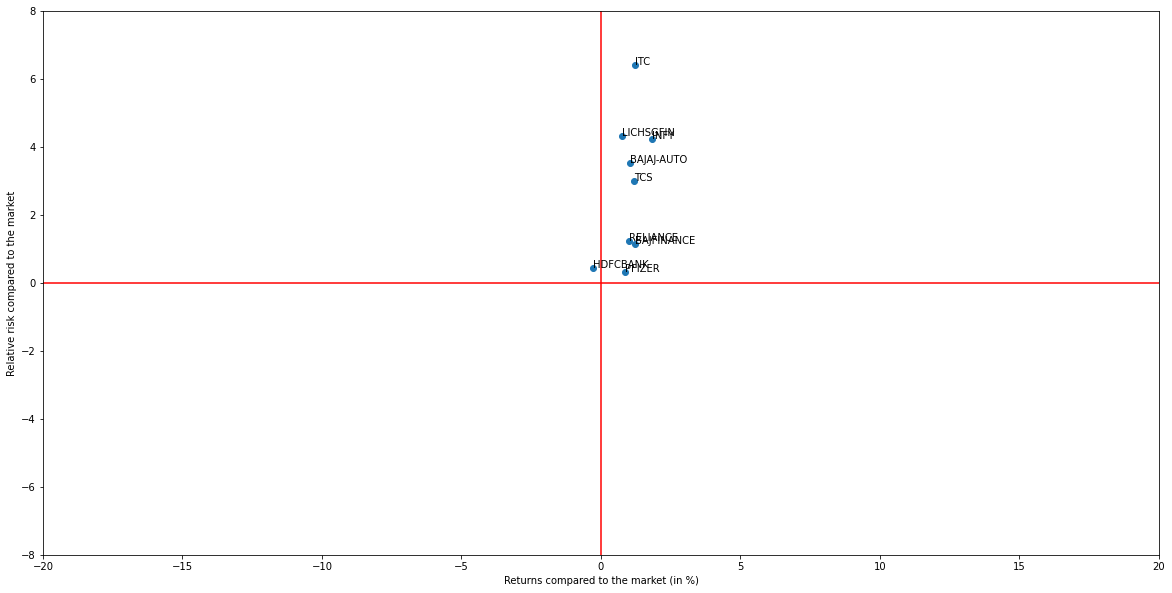

In [24]:
alpha = []
beta = []

for i in modelSelection:
    alpha.append(i[3])
    beta.append(i[4])

plt.figure(figsize = (20, 10))
plt.scatter(alpha, beta)
for i in range(0, len(modelSelection)):
    plt.annotate(modelSelection[i][0], (alpha[i], beta[i]))
plt.axhline(y=0, color='r')
plt.axvline(x=0, color='r')
plt.xlim(-20,20)
plt.ylim(-8,8)
plt.xlabel("Returns compared to the market (in %)")
plt.ylabel("Relative risk compared to the market")
